# Constants

In [ ]:
WORK_DIR_PATH = ".."

# Split
FILTER_BY = "user"
TRN_VAL_TST_RATIO = [0.8, 0.1, 0.1]
TRN_NEG_PER_POS_RATIO = 1
NEG_PER_POS_RATIO = [TRN_NEG_PER_POS_RATIO, TRN_NEG_PER_POS_RATIO, 100, 100]
BATCH_SIZE = [128, 128, 1, 1]

# Model
N_FACTORS = 32
HIDDEN = [N_FACTORS*2, N_FACTORS*2, N_FACTORS, N_FACTORS // 2]
DROPOUT = 0.2
MODEL_NAME = "NeuMF"

# How to Learn
TASK_TYPE = 'bpr'
LEARNING_RATE = 1e-4
LAMBDA_ = 1e-2

# Fit
N_EPOCHS = 100

# Config

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir(WORK_DIR_PATH)
print(f"DIRECTORY: {os.getcwd()}")

DIRECTORY: c:\Users\jayar\Desktop\바탕 화면\RESEARCH-MLP


In [3]:
import pandas as pd
import torch

In [4]:
import NeuMF
from MYUTILS import (
    ranking,
    utils,
)
from MYUTILS.config.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_LABEL_COL,
    DEFAULT_TIMESTAMP_COL,
    DEFAULT_PREDICTION_COL,
    DEFAULT_K,
    SEED,
)

In [5]:
# Seed
utils.seed.reset(SEED)

SETTING ALL SEEDS TO 42...
ALL SEEDS SET


In [6]:
# Available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Preparation

In [7]:
# Upload Data
DATA_NAME = "ml-100k.csv"
DATA_PATH = f"./data/{DATA_NAME}"
data = pd.read_csv(DATA_PATH)

In [8]:
# Columns
kwargs = dict(
    col_user='userId', 
    col_item='movieId', 
    col_rating='rating',
    col_timestamp='timestamp'
)

data = utils.data.rename_columns(data, **kwargs)


# Label encoding
kwargs = dict(
    data=data, 
    col_user=DEFAULT_USER_COL, 
    col_item=DEFAULT_ITEM_COL,
)

data, user_label, item_label = utils.data.label_encoding(**kwargs)


# Number of user, item
N_USERS = data[DEFAULT_USER_COL].nunique()
N_ITEMS = data[DEFAULT_ITEM_COL].nunique()

In [9]:
# data Description
utils.data.description(data)

number of user: 610
number of item: 9724
total interaction: 100836
interaction density: 1.7000 %
max interaction of user: 2698
top 10.0 % interaction of user: 400.3
mean interaction of user: 165
mean interaction of item: 10


In [ ]:
kwargs = dict(
    data=data,
    n_users=N_USERS,
    n_items=N_ITEMS,
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
)

dataloader = ranking.trn_val_tst.Module(**kwargs)

kwargs = dict(
    filter_by=FILTER_BY,
    trn_val_tst_ratio=TRN_VAL_TST_RATIO,
    neg_per_pos=NEG_PER_POS_RATIO,
    batch_size=BATCH_SIZE,
    seed=SEED,
    )

loaders, _ = dataloader.get(**kwargs)
trn_loader, val_loader, tst_loader, loo_loader = loaders

# Modeling

In [ ]:
kwargs = dict(
    n_users=N_USERS,
    n_items=N_ITEMS,
    n_factors=N_FACTORS,
    hidden=HIDDEN,
    dropout=DROPOUT,
    model_name=MODEL_NAME,
)

model = NeuMF.model.Module(**kwargs)

In [ ]:
kwargs = dict(
    model=model,
    trn_neg_per_pos_ratio=TRN_NEG_PER_POS_RATIO,
    task_type=TASK_TYPE,
    lr=LEARNING_RATE,
    lambda_=LAMBDA_,
)

loop = NeuMF.loop.Module(**kwargs)

# Train

In [ ]:
kwargs = dict(
    trn_loader=trn_loader,
    val_loader=val_loader,
    n_epochs=N_EPOCHS,
)

history = loop.fit(**kwargs)

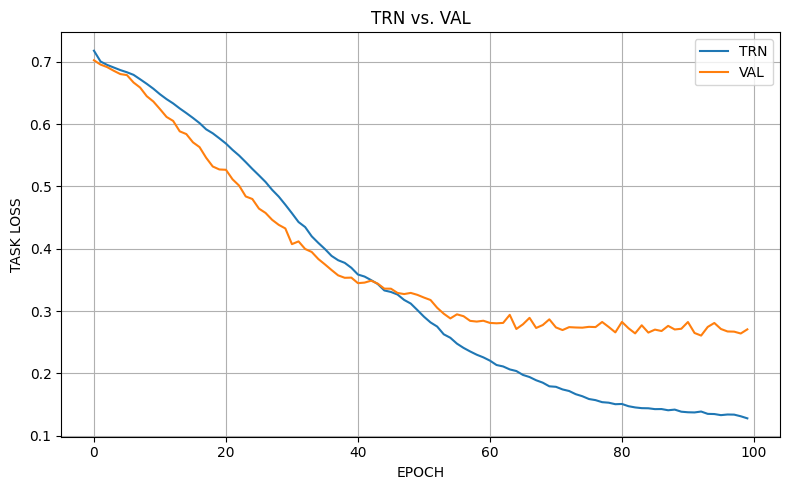

In [ ]:
utils.vis.plot_loss(history, 'TASK LOSS')

# Test

In [ ]:
TRUE_COL_LIST = [DEFAULT_USER_COL, DEFAULT_ITEM_COL, DEFAULT_LABEL_COL]
PRED_COL_LIST = [DEFAULT_USER_COL, DEFAULT_ITEM_COL, DEFAULT_PREDICTION_COL]

### TST Data

In [ ]:
kwargs = dict(
    tst_loader=tst_loader,
)

result_tst = loop.predict(**kwargs)

TST: 100%|██████████| 10024/10024 [00:15<00:00, 632.40it/s]


In [ ]:
TOP_K = 5

kwargs = dict(
    model_name=model.model_name,
    origin=data,
    rating_true=result_tst[TRUE_COL_LIST],
    rating_pred=result_tst[PRED_COL_LIST],
    k=TOP_K,
)

eval = ranking.metrics.eval_top_k(**kwargs)

HR@5: 0.800000
PRECISION@5: 0.324918
RECALL@5: 0.253442
MAP@5: 0.173873
NDCG@5: 0.380316
AGGDIV@5: 0.136393
MEAN NOVELTY@5: 9.609145
MEAN SERENDIPITY@5: 0.286557
PERSONALIZATION@5: 0.965512


In [ ]:
TOP_K = 10

kwargs = dict(
    model_name=model.model_name,
    origin=data,
    rating_true=result_tst[TRUE_COL_LIST],
    rating_pred=result_tst[PRED_COL_LIST],
    k=TOP_K,
)

eval = ranking.metrics.eval_top_k(**kwargs)

HR@10: 0.908197
PRECISION@10: 0.266557
RECALL@10: 0.379301
MAP@10: 0.220428
NDCG@10: 0.405234
AGGDIV@10: 0.132459
MEAN NOVELTY@10: 9.973401
MEAN SERENDIPITY@10: 0.232787
PERSONALIZATION@10: 0.964754


In [ ]:
TOP_K = 15

kwargs = dict(
    model_name=model.model_name,
    origin=data,
    rating_true=result_tst[TRUE_COL_LIST],
    rating_pred=result_tst[PRED_COL_LIST],
    k=TOP_K,
)

eval = ranking.metrics.eval_top_k(**kwargs)

HR@15: 0.952459
PRECISION@15: 0.230383
RECALL@15: 0.465300
MAP@15: 0.242812
NDCG@15: 0.428183
AGGDIV@15: 0.131366
MEAN NOVELTY@15: 10.245131
MEAN SERENDIPITY@15: 0.200765
PERSONALIZATION@15: 0.964528


In [ ]:
TOP_K = 20

kwargs = dict(
    model_name=model.model_name,
    origin=data,
    rating_true=result_tst[TRUE_COL_LIST],
    rating_pred=result_tst[PRED_COL_LIST],
    k=TOP_K,
)

eval = ranking.metrics.eval_top_k(**kwargs)

HR@20: 0.968852
PRECISION@20: 0.204016
RECALL@20: 0.514522
MAP@20: 0.255609
NDCG@20: 0.442386
AGGDIV@20: 0.131803
MEAN NOVELTY@20: 10.471999
MEAN SERENDIPITY@20: 0.176803
PERSONALIZATION@20: 0.964320


In [ ]:
TOP_K = 50

kwargs = dict(
    model_name=model.model_name,
    origin=data,
    rating_true=result_tst[TRUE_COL_LIST],
    rating_pred=result_tst[PRED_COL_LIST],
    k=TOP_K,
)

eval = ranking.metrics.eval_top_k(**kwargs)

HR@50: 0.998361
PRECISION@50: 0.130393
RECALL@50: 0.689283
MAP@50: 0.286049
NDCG@50: 0.495261
AGGDIV@50: 0.124885
MEAN NOVELTY@50: 11.315392
MEAN SERENDIPITY@50: 0.103311
PERSONALIZATION@50: 0.962671


In [ ]:
TOP_K = 100

kwargs = dict(
    model_name=model.model_name,
    origin=data,
    rating_true=result_tst[TRUE_COL_LIST],
    rating_pred=result_tst[PRED_COL_LIST],
    k=TOP_K,
)

eval = ranking.metrics.eval_top_k(**kwargs)

HR@100: 1.000000
PRECISION@100: 0.085311
RECALL@100: 0.789129
MAP@100: 0.299574
NDCG@100: 0.529562
AGGDIV@100: 0.108984
MEAN NOVELTY@100: 12.100945
MEAN SERENDIPITY@100: 0.062082
PERSONALIZATION@100: 0.960202


### Leave-One-Out Data

In [ ]:
kwargs = dict(
    tst_loader=loo_loader,
)

result_loo = loop.predict(**kwargs)

TST: 100%|██████████| 610/610 [00:00<00:00, 1007.66it/s]


In [ ]:
TOP_K = 5

kwargs = dict(
    model_name=model.model_name,
    origin=data,
    rating_true=result_loo[TRUE_COL_LIST],
    rating_pred=result_loo[PRED_COL_LIST],
    k=TOP_K,
)

eval = ranking.metrics.eval_top_k(**kwargs)

HR@5: 0.662295
PRECISION@5: 0.132459
RECALL@5: 0.662295
MAP@5: 0.455656
NDCG@5: 0.507078
AGGDIV@5: 0.432131
MEAN NOVELTY@5: 10.994508
MEAN SERENDIPITY@5: 0.124918
PERSONALIZATION@5: 0.995382


In [ ]:
TOP_K = 10

kwargs = dict(
    model_name=model.model_name,
    origin=data,
    rating_true=result_loo[TRUE_COL_LIST],
    rating_pred=result_loo[PRED_COL_LIST],
    k=TOP_K,
)

eval = ranking.metrics.eval_top_k(**kwargs)

HR@10: 0.773770
PRECISION@10: 0.077377
RECALL@10: 0.773770
MAP@10: 0.470783
NDCG@10: 0.543380
AGGDIV@10: 0.394754
MEAN NOVELTY@10: 11.682052
MEAN SERENDIPITY@10: 0.070984
PERSONALIZATION@10: 0.994978


In [ ]:
TOP_K = 15

kwargs = dict(
    model_name=model.model_name,
    origin=data,
    rating_true=result_loo[TRUE_COL_LIST],
    rating_pred=result_loo[PRED_COL_LIST],
    k=TOP_K,
)

eval = ranking.metrics.eval_top_k(**kwargs)

HR@15: 0.832787
PRECISION@15: 0.055519
RECALL@15: 0.832787
MAP@15: 0.475482
NDCG@15: 0.559063
AGGDIV@15: 0.370710
MEAN NOVELTY@15: 12.144478
MEAN SERENDIPITY@15: 0.050164
PERSONALIZATION@15: 0.994559


In [ ]:
TOP_K = 20

kwargs = dict(
    model_name=model.model_name,
    origin=data,
    rating_true=result_loo[TRUE_COL_LIST],
    rating_pred=result_loo[PRED_COL_LIST],
    k=TOP_K,
)

eval = ranking.metrics.eval_top_k(**kwargs)

HR@20: 0.868852
PRECISION@20: 0.043443
RECALL@20: 0.868852
MAP@20: 0.477498
NDCG@20: 0.567567
AGGDIV@20: 0.347705
MEAN NOVELTY@20: 12.502538
MEAN SERENDIPITY@20: 0.038852
PERSONALIZATION@20: 0.994203
